## Простая классификация текста с Transformers: анализ отзывов о банках. Fine-tuning RuBERT

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, classification_report

2024-07-10 13:44:42.718034: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 13:44:42.770337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 13:44:43.667165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Cчитываем данные. В нашем случае это отзывы о банках

In [2]:
df = pd.read_csv('../data/banks.csv', sep='\t', index_col='idx')

In [3]:
df.head()

,Score,Text
idx,,
0,Positive,В Альфа-Банке работает замечательная девушка -...
1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,Positive,Очень порадовала оперативность работы в банке....
3,Negative,Имела неосторожность оформить потреб. кредит в...
4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...


In [4]:
score_value_counts = df['Score'].value_counts()

In [5]:
score_value_counts

Score
Positive    7000
Negative    6999
Name: count, dtype: int64

### Как мы видим существует два отношения к ситуации, произошейдшей в банке - положительная и негативная. 

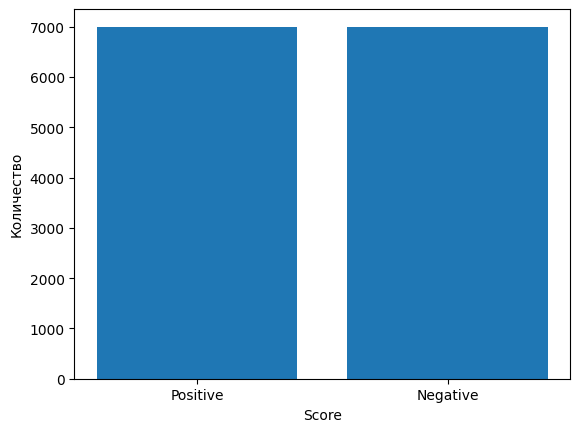

In [6]:
plt.bar(score_value_counts.index, score_value_counts.values)
plt.xlabel('Score')
plt.ylabel('Количество')
plt.show()

### Создаем токинизатор

In [7]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [8]:
df['Score'] = df['Score'].map({
    'Positive': 1, 
    'Negative': 0
})

In [9]:
df.rename(columns={'Text': 'text', 'Score': 'label'}, inplace=True)

### Разбиваем выборку на обучающую и тестовую

In [10]:
train_dataset, test_dataset = train_test_split(df, test_size=0.05)

### Разбиваем выфборку на обучающую и валидационную

In [11]:
train_dataset, eval_dataset = train_test_split(train_dataset, test_size=0.15)

In [12]:
train_dataset = Dataset.from_dict(train_dataset)
eval_dataset = Dataset.from_dict(eval_dataset)
test_dataset = Dataset.from_dict(test_dataset)

### Создаем функцию для преобразования текста в токены

In [13]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

### Токенизируем данные

In [14]:
tokenized_train_dataset = train_dataset.map(
    preprocess_function,   
    batched=True,
)

Map:   0%|          | 0/11304 [00:00<?, ? examples/s]

In [15]:
tokenized_eval_dataset = eval_dataset.map(
    preprocess_function,   
    batched=True,
)

Map:   0%|          | 0/1995 [00:00<?, ? examples/s]

In [16]:
tokenized_test_dataset = test_dataset.map(
    preprocess_function,   
    batched=True,
)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

### Создадим коллатор

In [17]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Создаем функцию, в которой будет высчитываться качество обучения нашей модели

In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


### Создадим два словаря, они связывают номера классов с их соответствующими метками, и наоборот

In [19]:
id2label = {
    0: 'Negative', 
    1: 'Positive'
}

label2id = {
    'Negative': 0, 
    'Positive': 1
}

### Загружаем уже обученную модель и определяем количество классов, которые модель сможет распознавать после обучения

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

/home/osipov/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Определяем аргументы для обучения

In [21]:
training_args = TrainingArguments(
    output_dir="rubert_fine-tuning", # каталог для сохранения результатов обучения
    learning_rate=2e-5, # скорость обучения
    per_device_train_batch_size=16, # размер батча для обучения
    per_device_eval_batch_size=16, # размер батча для оценки
    num_train_epochs=3, # количество эпох обучения
    weight_decay=0.01, # коэффициент регуляризации
    evaluation_strategy="epoch", # стратегия оценки
    save_strategy="epoch", # стратегия сохранения модели
    load_best_model_at_end=True, # загружает лучшую модель в конце обучения
    bf16=True, # bfloat16 тренировка
)

/home/osipov/.local/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Создаем объект Trainer, который будет управлять обучением. 

In [22]:
trainer = Trainer(
    model=model, # модель для обучения
    args=training_args, # аргументы для обучения
    train_dataset=tokenized_train_dataset, # обучающие данные
    eval_dataset=tokenized_eval_dataset, # тестовые данные
    tokenizer=tokenizer, # токенизатор
    data_collator=data_collator, # коллатор
    compute_metrics=compute_metrics, # функция для вычисления метрик
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


### Запускаем процесс обучения модели

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.279600,0.199020,0.938847,0.934899,0.983165,0.891150
2,0.165200,0.211722,0.947368,0.946126,0.954451,0.937945
3,0.069700,0.239275,0.951880,0.950413,0.965373,0.935910


TrainOutput(global_step=2121, training_loss=0.15317810351755304, metrics={'train_runtime': 20031.3456, 'train_samples_per_second': 1.693, 'train_steps_per_second': 0.106, 'total_flos': 8922622109368320.0, 'train_loss': 0.15317810351755304, 'epoch': 3.0})

### Сохраняем модель

In [24]:
model_path = "../models/fine-tune_rubert"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('../models/fine-tune_rubert/tokenizer_config.json',
 '../models/fine-tune_rubert/special_tokens_map.json',
 '../models/fine-tune_rubert/vocab.txt',
 '../models/fine-tune_rubert/added_tokens.json',
 '../models/fine-tune_rubert/tokenizer.json')

### Функция для получения предикта

In [25]:
def get_prediction():
    test_pred = trainer.predict(tokenized_test_dataset)
    labels = np.argmax(test_pred.predictions, axis = -1)
    return labels
pred = get_prediction()

In [26]:
test_labels = test_dataset['label']

### Вывод всей необходимой информации для оценки качества модели

In [27]:
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       344
           1       0.99      0.90      0.95       356

    accuracy                           0.95       700
   macro avg       0.95      0.95      0.95       700
weighted avg       0.95      0.95      0.95       700



### По итогу получаю F1 = 0.95! Это довольно крутой результат, который можно улучшить

### Теперь создадим прогнозы имитировав пользователя

In [28]:
from transformers import pipeline

In [29]:
classifier = pipeline(
    'text-classification',
    'result_ruber/checkpoint-3940'
)

In [30]:
tests = [
    'Недавно была в Сбербанке и это какой-то ужас! Мало того, что огромные и длинные очереди, так еще мне хамят! БЕСПРЕДЕЛ',
    'Какие же хорошие люди у нас работают в Альфа-Банке. А девушка какая там миловидная!! Красота',
    """Добрый день! Я являюсь ИП и стоял перед выбором банка для открытия расчетного счета. Посоветовали обратиться в Россельхозбанк, что я и сделал , и не прогадал. Теперь хочу рассказать о моем впечатлении , может быть это тоже поможет кому нибудь сделать выбор ! Офис расположен удобно, электронная очередь обеспечивает порядок и дисциплину. После взятия талона вызвали через 2 минуты к специалисту. Мне подробно рассказали про условия счета, про возможность проведения платежных поручений, про мобильное приложение. На все вопросы ответили, приложение подключили и рассказали, как им пользоваться. Всего минут 10 и мою потребность полностью удовлетворили. Сотрудник просто грамотно и на понятном нам клиентам языке рассказал все, открыто и без всяких подводных камней. Это приятно удивляет. Так же я рассказал, что планирую кредитоваться и узнал условия текущие по кредитам. С этим вопросом мне надо подумать, так что мы с сотрудником обменялись контактными данными для связи и назначения встречи в офисе банка в дальнейшем. Хочу сказать спасибо коллективу отделения Россельхозбанка в Элисте и руководителю за ценный вклад в развитие своих сотрудников ! Всем желаю успехов, а банку процветания.""",
    """14 января 2023 года была попытка перевода денег в размере 15 тыс клиенту другого банка, но произошел какой-то сбой в приложении, деньги с карты списались, но до получателя не дошли. Начали звонить в техподдержку, ощущение что там сидят вчерашние школьники. Нам обещали что через пять рабочих дней деньги вернуться, прошло пять дней, звоним, там нам очередной профи сообщает что предыдущий оператор не так оформил заявку, через пару дней все исправят, проходит еще пару дней, следующий оператор утверждает что надо не в такой форме заявку подать, и через день все вернется.... потом мы поехали в офис Альфа банка, там заверили что в течении суток все решится, но само собой ничего не решилось, нам написали что нужно еще пару дней подождать... Сегодня 01.02.2023 деньги висят в блокировке!!!! То ли в Альфа банке в принципе такое отношение к клиентам, либо там работают полнейшие непрофи (это я корректно выразилась, хотя очень хочется назвать по другому), что тоже говорит само за себя. Альфа банк, команда непрофессионалов. Не рекомендую пользоваться услугами этого банка.""",
]

In [31]:
for test in tests:
    print(classifier(test))

[{'label': 'Negative', 'score': 0.9994066953659058}]
[{'label': 'Positive', 'score': 0.9998844861984253}]
[{'label': 'Positive', 'score': 0.9999184608459473}]
[{'label': 'Negative', 'score': 0.9993094205856323}]
